In [15]:
from neurotic import RNN
from neurotic.utility import GlExtract, Plotlib, TexRact, ColabConfig
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
import pydot
from math import ceil

In [ ]:
#COLAB DRIVE MOUNT
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [2]:
cases, summaries = TexRact.load_arrays("aus_clean_stops.pkl")

In [3]:
print(summaries[20])

application for extension of time for review of decision of this court made almost eight years earlier  that decision dismissed application for review of earlier tribunal decision adverse to same applicant  subsequent joinder of applicant to substantial class action later dismissed  thereafter unsuccessful application to federal magistrates court to review original tribunal decision  thereafter present application for extension of time  present application dismissed  migration


In [4]:
vocab_length = 15000
tokenized_cases, tokenized_summaries, vocab, reverse_vocab = TexRact.tokenize(cases, summaries, vocab_length)
print(tokenized_summaries[20])

Found 89605 unique tokens.
[51, 10, 883, 2, 68, 10, 153, 2, 56, 2, 26, 33, 45, 2117, 1791, 363, 415, 5, 56, 476, 51, 10, 153, 2, 415, 42, 56, 1313, 3, 202, 32, 1141, 3072, 2, 32, 3, 591, 663, 209, 490, 476, 1549, 2201, 51, 3, 116, 622, 33, 3, 153, 657, 42, 56, 1549, 187, 51, 10, 883, 2, 68, 187, 51, 476, 495]


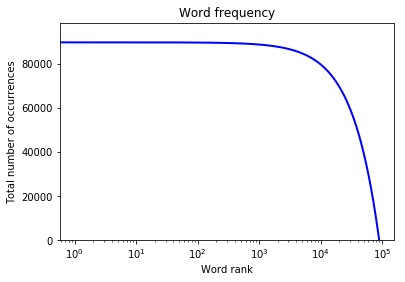

In [5]:
Plotlib.plot_word_chart(vocab)

In [6]:
min_case, max_case = TexRact.min_max_seq(tokenized_cases)
min_sum, max_sum = TexRact.min_max_seq(tokenized_summaries)
print("Cases length minimum: ", min_case, ", maximum: ", max_case)
print("Summaries length minimum: ", min_sum, ", maximum: ", max_sum)

Cases length minimum:  111 , maximum:  428440
Summaries length minimum:  2 , maximum:  1001


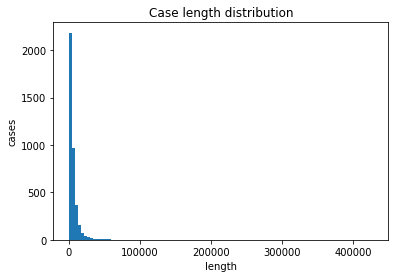

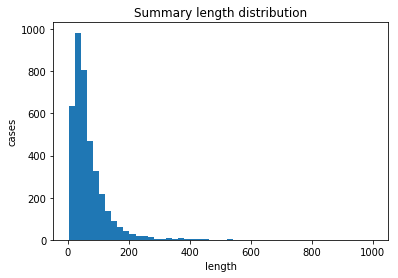

In [7]:
Plotlib.plot_length_chart(tokenized_cases, "Case length distribution", bin_count=100)
Plotlib.plot_length_chart(tokenized_summaries, "Summary length distribution", bin_count=50)

In [8]:
case_len = 20000
summary_len = 150
batch_size = 124
num_samples = 2332
num_epochs = 40
validation_split = 0.1
embedding_dim = 100

In [9]:
input_sequences = pad_sequences(tokenized_cases, maxlen=case_len, padding='post', truncating='pre')
output_sequences = pad_sequences(tokenized_summaries, maxlen=summary_len, padding='post', truncating='post')

In [10]:
del cases, summaries, tokenized_cases, tokenized_summaries

In [11]:
X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_sequences, test_size=0.2, random_state=42)
nb_validation_samples = int(validation_split * X_train.shape[0])
X_val = X_train[-nb_validation_samples:]
y_val = y_train[-nb_validation_samples:]
X_train = X_train[:-nb_validation_samples]
y_train = y_train[:-nb_validation_samples]
num_samples = num_samples - nb_validation_samples

In [12]:
embeddings_index, embedding_matrix = GlExtract.build_glove_embeddings(vocab, embedding_dim)

Found 400000 word vectors.


In [13]:
one_shot = RNN.build_one_shot_model(vocab_length, case_len, summary_len, embedding_matrix)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
one_shot.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 20000)             0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 20000, 100)        1500000   
_________________________________________________________________
Encoder-LSTM (LSTM)          (None, 100)               80400     
_________________________________________________________________
Encoder-output (RepeatVector (None, 150, 100)          0         
_________________________________________________________________
Decoder-LSTM (LSTM)          (None, 150, 100)          80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 15000)        1515000   
_________________________________________________________________
activation (Activation)      (None, 150, 15000)        0         
Total para

In [16]:
plot_model(one_shot, to_file='one_shot_graph.png')

<img src="files/one_shot_graph.png">

In [18]:
train_data_generator = RNN.KerasBatchGenerator(X_train, y_train, case_len, summary_len, batch_size, vocab_length)
val_data_generator = RNN.KerasBatchGenerator(X_val, y_train, case_len, summary_len, batch_size, vocab_length)

In [ ]:
#COLAB TPU CONFIG ONLY
ColabConfig.configure_tpu_colab(one_shot)
tf.keras.backend.get_session().run(tf.global_variables_initializer())

In [ ]:
checkpointer = ModelCheckpoint('model-{epoch:02d}.hdf5', verbose=1)
one_shot_history = one_shot.fit_generator(train_data_generator.generate(),
                                 steps_per_epoch=ceil(num_samples/batch_size),
                                 epochs=num_epochs,
                                 validation_data = val_data_generator.generate(),
                                 validation_steps = ceil(nb_validation_samples/batch_size))

In [ ]:
RNN.save_model(one_shot, one_shot_history, "one_shot_40_ep")